# LOG6308
# TP3 : Systèmes de recommandation et réseaux de neurones

L'objectif du TP3 est de vous familiariser avec la librairie `Tensorflow` et `Tensorflow Recommenders`. Nous souhaitons aussi vous familiariser avec le concept de réseaux neuronaux.
C'est pourquoi nous vous proposons d'effectuer des recommandations de films sur la base de données que vous connaissez bien maintenant : [MovieLens 100k](https://grouplens.org/datasets/movielens/).<br>

Le TP sera noté **sur 100**.

## Critères de correction

- Démarche valide et bien expliquée
- Réponses correctes et commentées
- Présentation soignée 
- Choix de fonctionnalités adéquat
- Interprétation étayée des résultats

## Instructions Globales

Le travail doit être fait en **équipe de deux**.

Vous avez le droit d'utiliser **seulement** les **librairies importées** pour résoudre les **questions 1, 2 et 3**. Si vous utilisez d’autres librairies, vos réponses ne seront pas considérées.

Vous pouvez répondre aux sous-questions en commentaire ou dans des cellules textes en prenant bien soin d’identifier à quelle question vous répondez.
Ceux qui le souhaite peuvent développer en local et écrire votre code dans des fichiers Python en `.py`. Ceci dit, j'attends de vous un README.md m'expliquant comment exécuter votre code avec une liste de dépendances (Requirements).

Pour les questions 1-2-3, le Notebook est suffisant. Vous pouvez marquer vos commentaires et réponses qualitatives dans des cellules textes. 
Par contre, pour la question 4, il est recommandé de fournir un rapport séparé du code en format PDF. Mais, si vous ne souhaitez pas rédiger de rapport, vous pouvez rédiger votre état de l’art et votre démarche dans des cellules textes du Notebook sur Colab.


Pour la remise du travail sur Moodle, on s’attend à un Zip qui contient un notebook en `.ipynb` et/ou des fichiers Python en `.py`. **Si vous décidez** de **rédiger un rapport** pour la **question 4**, vous devez alors aussi **inclure** un fichier **PDF**. 


### Comment télécharger le notebook

- Cliquez sur le menu "Fichier" (*File* en anglais) dans le coin supérieur gauche.
- Une fenêtre popup apparaît, trouvez `Télécharger -> Télécharger le fichier .ipynb` et cliquez dessus.


#### Installation de tensorflow datasets, tensorflow recommenders, et importation des librairies requises pour le TP

In [3]:
!pip install tfds-nightly
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets==4.3
!pip install -q scann

     |████████████████████████████████| 4.3 MB 8.8 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 
     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 462 kB 45.8 MB/s 
     |████████████████████████████████| 3.9 MB 9.0 MB/s 
     |████████████████████████████████| 10.7 MB 8.3 MB/s 


In [5]:
import os
import pprint
import tempfile

from tqdm import tqdm
from typing import Dict, Text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

## Utilisation du GPU
Les calculs seront plus rapides si vous utilisez le GPU. Ça sera particulièrement important pour la dernière partie. Pour s'assurer que le notebook utilise le GPU, vous pouvez modifier la configuration ainsi :
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`

Par contre, faites attention à ne pas utiliser le GPU si vous n'en avez pas besoin. Colab limite le temps d'utilisation des GPUs pour sa version gratuite.

In [6]:
#Test CPU ou GPU
if(len(tf.config.list_physical_devices('GPU')) == 0):
    print("Vous utilisez actuellement le CPU")
else:
    print("Vous utilisez actuellement le GPU")

Vous utilisez actuellement le GPU


#### Téléchargement de MovieLens 100k

Vous pouvez accéder à la documentation en appuyant sur ce [lien](https://www.tensorflow.org/datasets/catalog/movielens#movielens100k-ratings).

In [29]:
# Extra code
#!unrar x Data.rar
movies_df  = pd.read_csv('Data/items.csv', sep='|')
ratings_df = pd.read_csv('Data/votes.csv', sep='|')
ratings_df = ratings_df.rename(columns={'user.id': 'user_id', 'item.id': 'movie_title', 'rating': 'user_rating', 'timestamp': 'timestamp'})
ratings_df = ratings_df.astype('float32')
ratings = tf.data.Dataset.from_tensor_slices(tf.cast(ratings_df.values, tf.float32))
films = ratings

# Les votes + des données supplémentaires
##ratings = tfds.load("movielens/100k-ratings", split="train", shuffle_files = False)
# Les genres, titres et identifiants des films.
##films = tfds.load("movielens/100k-ratings", split="train", shuffle_files = False)

In [ ]:
#tfds
type(ratings)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

Comme vous le voyez, `ratings` et `films` sont générés par `tfds` et sont des `tf.data.Dataset`. Pour avoir une idée de comment les utilisées, vous pouvez consulter ces liens : <br>
- [DataSet](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
- [tfds](https://www.tensorflow.org/datasets/overview)

In [ ]:
# Exemple d'utilisation
##list(ratings.map(lambda x: x["user_id"]).take(10))
list(ratings.map(lambda x: x[2]).take(10))
print(min(ratings.map(lambda x: x[2])))

tf.Tensor(1.0, shape=(), dtype=float32)


## Question 1 (15 pts)
Dans cette question, nous allons définir et entrainer un modèle dit *Two Tower* afin de prédire les votes selon cette formule :

$$pred_{i,j}= b + E_{u_i}^TE_{f_j}.$$


Où $(E_{u_i}, E_{f_j}) \in \mathbb{R}^n \times \mathbb{R}^n$ sont respectivement les plongements (<i>embeddings</i>) de l'utilisateur $i$, $u_i$, et du film $j$, $f_j$. De plus, $b \in \mathbb{R}$ est la constante qui représente la moyenne. Enfin, $n \in \mathbb{N}$ est respectivement la dimension de l'espace latent des utilisateurs et des films (dans cette question, $n=32$).

<br>

***Pour répondre aux questions, vous devez remplacer les `?` par les valeurs adéquates.***

### 1.1. Extraire les attributs nécessaires pour entrainer le modèle (1 pt)

On vous demande d'extraire des données les `titres de films`, les `identifiants utilisateurs`, les `votes`, et les `horodatages` (<i>timestamps</i>). Les données doivent être sous format chaine de caractères (`str`). Voici la [doc](https://www.tensorflow.org/datasets/catalog/movielens#movielens100k-ratings). <br><br>
*À modifier si vous voulez inclure d'autres features pour les questions 3 et 4.*

In [30]:
#votes = ratings.map(lambda x: {"?": x["?"],"?": x["?"],"?": x["?"], "?": tf.strings.as_string(x["?"])})
votes = ratings.map(lambda x: {"movie_title": tf.strings.as_string(x[1]),"user_id": tf.strings.as_string(x[0]), "user_rating": x[2], "timestamp": x[3]})
films = votes

### 1.2. Statistiques sur les données de `MovieLens 100k`

#### 1.2.a Affichez le nombre d'utilisateurs uniques (1 pt)

In [ ]:
#Identifiant des utilisateurs
id_utilisateurs = votes.map(lambda x: x["user_id"]).batch(1000000)# On prend tous les utilisateurs d'un coup
id_uniques      = np.unique(np.concatenate(list(id_utilisateurs)))
nb_id_uniques   = id_uniques.shape[0]
nb_id_uniques

943

#### 1.2.b Affichez le nombre de films uniques (1 pt)

In [ ]:
#Titres des films
titres_films    = films.map(lambda x: x["movie_title"]).batch(1000000)# On prend tous les films d'un coup
films_unique    = np.unique(np.concatenate(list(titres_films)))
nb_films_unique = films_unique.shape[0]
nb_films_unique

1682

#### 1.2.c Affichez le nombre de votes et les fréquences de paires (utilisateurs, films) uniques. Constatez-vous des anomalies ? Si oui, quelles sont-elles ? (3 pts)

In [ ]:
## Number of votes
number_of_votes = len(votes)
print("The number of votes is {}".format(number_of_votes))
## Unique pairs
unique_pairs = nb_id_uniques * nb_films_unique
print("The number of unique pairs is {}".format(unique_pairs))
print("Therefore, we can see that we have a very sparse dataset, with only {}% of possible values present.".format((number_of_votes/unique_pairs)*100))
print("We either have to treat this sparsity somehow, or create embeddings to encapsulate only the present values.")


The number of votes is 100000
The number of unique pairs is 1586126
Therefore, we can see that we have a very sparse dataset, with only 6.304669364224531% of possible values present.
We either have to treat this sparsity somehow, or create embeddings to encapsulate only the present values.


### 1.3. Initialisation de la metrique RMSE de tfrs (1 pt)

Soit $y\in \mathbb{R}^N$ un vecteur de valeur de votes issue de la base de données d'entrainement, et $\hat{y} \in \mathbb{R}^N$ la prédiction de ces votes par notre modèle. Pour que notre modèle soit performant, nous aimerions bien que $\hat{y}$ ait quasiment les mêmes valeurs que $y$. On cherche donc à minimiser la perte suivante, qui est la **MSE** (*Mean Square Error*) :

<br>

$$\boxed{l(\hat{y}, y) = ||\hat{y}-y||_2^2 = \cfrac{1}{N}\underset{i=1}{\overset{N}{\sum }}|\hat{y} - y|^2}.$$

<br>

Initialisez la tâche avec la perte adéquate en utilisant `tfrs.tasks.Ranking`, voici la [doc](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/tasks/Ranking). Il faut donc utiliser `tf.keras.losses.MeanSquaredError()` comme **perte**, et `tf.keras.metrics.RootMeanSquaredError()` comme **métrique**.

In [31]:
task = tfrs.tasks.Ranking(loss = tf.keras.losses.MeanSquaredError(), metrics = [tf.keras.metrics.RootMeanSquaredError()])

### 1.4. Définition du modèle Two Towers


#### 1.4.1. On définit la dimension de l'espace latent (taille des plongements) comme étant égale à 32. Pourquoi ne pas avoir choisi une dimension plus élevée ? (1 pt)<br>

<u>Réponse</u> :<br>
Embedding words in a high dimension space requires more data to enforce density and significance of the representation, becoming hard to compute and converge in high dimensional spaces.

In [ ]:
embedding_dimension = 32

#### 1.4.2. Définir les couches de plongement pour les utilisateurs et les films (1 pt)

Pour initaliser les espaces de plongements, vous pouvez vous aider de la documentation de [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).<br>

Pour comprendre `tf.keras.layers.experimental.preprocessing.StringLookup`, aidez-vous de la [doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup).

In [ ]:
def initialisation_embeddings(embedding_dimension, id_uniques, films_unique):
    user_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=id_uniques, mask_token=None),
                                    tf.keras.layers.Embedding(len(id_uniques) + 1,# Le +1 représente la constante $c$
                                                                embedding_dimension)], name="User_Embedding")

    movie_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=films_unique,mask_token=None),
                                    tf.keras.layers.Embedding(len(films_unique) + 1, 
                                                                embedding_dimension)], name="Movie_Embedding")  
    return user_model, movie_model

#### 1.4.3. Assemblez le modèle *Two Towers* (2 pts)

In [ ]:
class MovieLensModel(tfrs.models.Model):

  def __init__(self, embedding_dimension, id_uniques, films_unique, task):
    super().__init__()
    self.user_model, self.movie_model = initialisation_embeddings(embedding_dimension, id_uniques, films_unique)
    
    self.pred = tf.keras.layers.Dot(axes=1)
    
    self.task: tf.keras.layers.Layer = task

  def call(self, features):
    user_embedding, movie_embedding = self.user_model(features["user_id"]), self.movie_model(features["movie_title"]) ## Embeddings extraction
    votes_predictions = self.pred([user_embedding, movie_embedding]) ## Scalar product of the two embeddings
    return votes_predictions
  
  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    
    return self.task(labels=features["user_rating"], predictions=self.call(features))

### 1.5. Entrainement du modèle
Dans cette partie, on entraine et test le modèle defini au dessus.

#### Définir les bases de données d'entrainement et de validation (proportion $80\%-20\%$).

In [36]:
N          = len(votes)
batch_size = 8192 #2^13
prop       = 0.8
train_len  = tf.cast(N * prop, dtype=tf.int64)
valid_len   = tf.cast(N - train_len, dtype=tf.int64)


# shuffled = votes.shuffle(N, seed=73, reshuffle_each_iteration=False)

tf.random.set_seed(73)
train = votes.take(train_len).shuffle(train_len, seed=73, reshuffle_each_iteration=False).batch(batch_size)
valid = votes.skip(train_len).take(valid_len).shuffle(valid_len, seed=73, reshuffle_each_iteration=False).batch(batch_size)

#### 1.5.1. Initialisez le modèle, l'optimiseur et les modules de callback pour l'entrainement (2 pts)

In [ ]:
# On tire un exemple pour construire le graphe du modèle
feature = next(iter(train))
feature

{'movie_title': <tf.Tensor: shape=(8192,), dtype=string, numpy=
 array([b'879.000000', b'882.000000', b'475.000000', ..., b'403.000000',
        b'451.000000', b'518.000000'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(8192,), dtype=float32, numpy=
 array([8.7956160e+08, 8.8818003e+08, 8.7564013e+08, ..., 8.8015149e+08,
        8.9103603e+08, 8.8491648e+08], dtype=float32)>,
 'user_id': <tf.Tensor: shape=(8192,), dtype=string, numpy=
 array([b'459.000000', b'206.000000', b'92.000000', ..., b'653.000000',
        b'210.000000', b'345.000000'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(8192,), dtype=float32, numpy=array([4., 1., 5., ..., 2., 3., 4.], dtype=float32)>}

In [ ]:
# On construit et affiche le modèle
Model = MovieLensModel(embedding_dimension, id_uniques, films_unique, task)
Model(feature)
Model.summary() # comment expliquez-vous le nombre de paramètres des couches embeddings ? (32*x, where x is the number of unique values of each variable)

Model: "movie_lens_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 User_Embedding (Sequential)  (8192, 32)               30208     
                                                                 
 Movie_Embedding (Sequential  (8192, 32)               53856     
 )                                                               
                                                                 
 dot (Dot)                   multiple                  0         
                                                                 
 ranking (Ranking)           multiple                  0 (unused)
                                                                 
Total params: 84,064
Trainable params: 84,064
Non-trainable params: 0
_________________________________________________________________


On utilise comme optimiseur `Adam` (voir la [doc](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)) qui prend $0.01$ comme valeur pour son `learning_rate`. On vous demande aussi d'utiliser la stratégie *early stopping* pour entrainer votre modèle (voir les explications [ici](https://www.educative.io/edpresso/what-is-early-stopping)). Cette stratégie est implémentée par `Keras` comme un module *callback*, voir la [doc](https://keras.io/api/callbacks/). La **patience** doit être égale à $3$.

In [ ]:
# Création du dossier contenant les modèles entrainés
#!mkdir Models/

# Compiler le modèle en ajoutant l'optimiseur Adam
Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

#### 1.5.2. Entrainez le modèle sur **15 epochs** et afficher les résultats ainsi que la meilleure **RMSE** sur l'ensemble de validation. Y a-t-il surapprentissage ? (2 pts)

In [ ]:
#Entrainement du modèle sur 15 epochs
history_TwoTowers = Model.fit(train, epochs=15, validation_data=valid, callbacks=my_callbacks)

Epoch 1/15
10/10 [==============================] - 10s 516ms/step - root_mean_squared_error: 3.7021 - loss: 13.6748 - regularization_loss: 0.0000e+00 - total_loss: 13.6748 - val_root_mean_squared_error: 3.6652 - val_loss: 13.4904 - val_regularization_loss: 0.0000e+00 - val_total_loss: 13.4904
Epoch 2/15
10/10 [==============================] - 12s 980ms/step - root_mean_squared_error: 3.5504 - loss: 12.4440 - regularization_loss: 0.0000e+00 - total_loss: 12.4440 - val_root_mean_squared_error: 3.3131 - val_loss: 11.0178 - val_regularization_loss: 0.0000e+00 - val_total_loss: 11.0178
Epoch 3/15
10/10 [==============================] - 8s 526ms/step - root_mean_squared_error: 2.9051 - loss: 8.1185 - regularization_loss: 0.0000e+00 - total_loss: 8.1185 - val_root_mean_squared_error: 2.3013 - val_loss: 5.2993 - val_regularization_loss: 0.0000e+00 - val_total_loss: 5.2993
Epoch 4/15
10/10 [==============================] - 8s 515ms/step - root_mean_squared_error: 1.6890 - loss: 2.6791 - reg

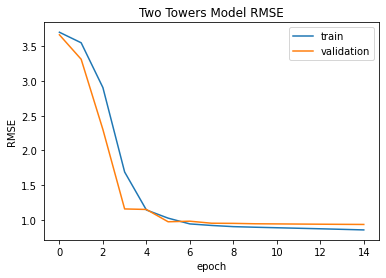



Best RMSE on validation : 0.9336


In [ ]:
def plot_history(history, model_name="Two Towers"):
    # summarize history for loss
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title(model_name + ' Model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
    print("\n\nBest RMSE on validation : {0:.4f}".format(min(history.history['val_root_mean_squared_error'])))

plot_history(history_TwoTowers, model_name="Two Towers")

L'overfitting n'a pas lieu de manière flagrande pendant les 15 premières epochs

## Question 2 (15 pts)

Modifier le modèle Two Tower pour prendre en compte le biais utilisateur et item (film). La nouvelle formule de prédiction est donc :

$$pred_{i,j}= \sigma(b + biais_{u_i} + biais_{f_j} +E_{u_i}^TE_{f_j}) \times (M_{vote} - m_{vote}) + m_{vote}$$

<br>

Où $biais_{u_i} \in \mathbb{R}$ est le biais associé à l'utilisateur $u_i$ et $biais_{f_j} \in \mathbb{R}$ le biais associé au film $f_j$. <br>

$\sigma: x \mapsto \cfrac{1}{1+e^{-x}}$ est la fonction sigmoid, elle est déjà implémentée par TensorFlow : `tf.math.sigmoid`.<br>

Et, $M_{vote}, m_{vote}$ sont respectivement le maximum et le minimum des votes utilisateurs. Dans notre cas, $M_{vote}=5$ et $m_{vote}=1$.

### Description du modèle Two Tower avec Biais

Le modèle Keras correspondant est légèrement plus complexe. En plus des plongements d'utilisateurs et de films avec lesquelles nous avons déjà travaillé, le modèle ci-dessous approxime le biais utilisateur ($biais_{u_i}$) et le biais film ($biais_{f_j}$) en plongeant l'utilisateur et le film dans un espace unidimensionnel. Nous ajoutons ensuite les deux biais au produit scalaire représentant l'interaction utilisateur-film. La fonction d'activation sigmoïde normalise et ramène la prédiction à l'intervalle $[0,1]$, qui est ensuite ramenée à l'intervalle de vote original $[m_{vote}, M_{vote}]$. D'ailleurs, le dropout doit être appliqué aux sorties des couches `user_model` et `movie_model`.


### Définissez, initialisez, entrainez, affichez et interprétez les résultats du modèle Two Tower modifié. Y a-t-il surapprentissage ?

Dans cette question, il vous ai conseillé d'utiliser Adam avec un `learning_rate`$=0.005$.

In [ ]:
#MovieLensModelWithBias Herite des attributs et des méthodes de MovieLensModel
class MovieLensModelWithBias(MovieLensModel):

  def __init__(self, embedding_dimension, id_uniques, films_unique, task, min_vote=1, max_vote=5, user_dropout=0.3, movie_dropout=0.6):
    super().__init__(embedding_dimension, id_uniques, films_unique, task)

    self.min_vote, self.max_vote = min_vote, max_vote

    # Cette couche plonge dans un espace de dimension 1. Sa sortie est une constante qui représente le biais utilisateur.
    self.user_bias = user_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=id_uniques, mask_token=None),
                                    tf.keras.layers.Embedding(len(id_uniques) + 1, 1)], name="User_Bias")

    self.movie_bias = user_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=films_unique, mask_token=None),
                                    tf.keras.layers.Embedding(len(films_unique) + 1, 1)], name="Movie_Bias")
        
    self.user_dropout  = tf.keras.layers.Dropout(rate = user_dropout, name="User_Dropout")
    self.movie_dropout = tf.keras.layers.Dropout(rate = movie_dropout, name="Movie_Dropout")


  def call(self, features):
    user_embedding, movie_embedding = self.user_model(features["user_id"]), self.movie_model(features["movie_title"]) ## User-item extraction
    user_bias, movie_bias = self.user_bias(features["user_id"]), self.movie_bias(features["movie_title"]) ## Bias extraction
    
    user_embedding = self.user_dropout(user_embedding) ## User dropout
    movie_embedding = self.movie_dropout(movie_embedding) ## Item dropout

    user_item_product = self.pred([user_embedding,movie_embedding]) ## Dot product of the dropouts
    
    votes_predictions = tf.math.sigmoid(user_bias + movie_bias + user_item_product) * (self.max_vote - self.min_vote) + self.min_vote

    return votes_predictions

In [ ]:
#Initialisez le modèle et afficher ses couches (summary)
Model_Bias = MovieLensModelWithBias(embedding_dimension, id_uniques, films_unique, task, min_vote=1, max_vote=5, user_dropout=0.3, movie_dropout=0.6)
Model_Bias(feature)
Model_Bias.summary()

Model: "movie_lens_model_with_bias"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 User_Embedding (Sequential)  (8192, 32)               30208     
                                                                 
 Movie_Embedding (Sequential  (8192, 32)               53856     
 )                                                               
                                                                 
 dot_1 (Dot)                 multiple                  0         
                                                                 
 ranking (Ranking)           multiple                  0         
                                                                 
 User_Bias (Sequential)      (8192, 1)                 944       
                                                                 
 Movie_Bias (Sequential)     (8192, 1)                 1683      
                                        

In [ ]:
# Compilez le modèle en ajoutant l'optimiseur Adam
# Création du dossier contenant les modèles entrainés
#!mkdir Models/

# Compiler le modèle en ajoutant l'optimiseur Adam
Model_Bias.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
#Entrainez le modèle
history_TwoTowers_Model_Bias = Model_Bias.fit(train, epochs=15, validation_data=valid, callbacks=my_callbacks)

Epoch 1/15
10/10 [==============================] - 9s 546ms/step - root_mean_squared_error: 1.2274 - loss: 1.4965 - regularization_loss: 0.0000e+00 - total_loss: 1.4965 - val_root_mean_squared_error: 1.1936 - val_loss: 1.3926 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3926
Epoch 2/15
10/10 [==============================] - 10s 529ms/step - root_mean_squared_error: 1.1791 - loss: 1.3801 - regularization_loss: 0.0000e+00 - total_loss: 1.3801 - val_root_mean_squared_error: 1.1497 - val_loss: 1.2896 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2896
Epoch 3/15
10/10 [==============================] - 8s 530ms/step - root_mean_squared_error: 1.1190 - loss: 1.2402 - regularization_loss: 0.0000e+00 - total_loss: 1.2402 - val_root_mean_squared_error: 1.0907 - val_loss: 1.1577 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1577
Epoch 4/15
10/10 [==============================] - 8s 534ms/step - root_mean_squared_error: 1.0396 - loss: 1.0688 - regularizati

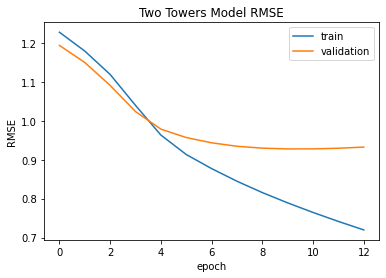



Best RMSE on validation : 0.9277


In [ ]:
#Affichez les résultats
def plot_history(history, model_name="Two Towers"):
    # summarize history for loss
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title(model_name + ' Model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
    print("\n\nBest RMSE on validation : {0:.4f}".format(min(history.history['val_root_mean_squared_error'])))

plot_history(history_TwoTowers_Model_Bias, model_name="Two Towers")

#### Observations

<u>Réponse</u> :<br>

We can see that the RMSE of the training set is considerably lower. We got a RMSE of 0.7129 after 14 epochs using the new methods that includes the bias, while we got 0.8549 in the previous method. For the validation sets, we also got a better result, even though not as marked: 0.9253 for the bias method, and 0.9336 for the previous method. For the divergence between the RMSE of the train and test validations, we can identify that our model is efficient, but is overfitting. 

## Question 3 (20 pts)
Dans cette question, nous cherchons à améliorer le modèle Two Towers avec les biais de la question 2. <br> 

Voici quelques idées d'améliorations : 

### Question 3.1 (10 pts)

Améliorez les performances en changeant les hyperparamètres du modèle (<i>dropout, embedding_dim, learning rate, etc...</i>). Quelle est l'impact de ces hyperparamètres sur le surapprentissage (<i>overfitting</i>) ? **(10 pts)**

In [ ]:
## Trying different dropouts
def test_dropouts():
  user_dropouts = [0.1, 0.3, 0.5, 0.7, 0.9]
  movie_dropouts = [0.1, 0.3, 0.5, 0.7, 0.9]
  min_rmse = float('inf')
  best_user_dropout = 0
  best_movie_dropout = 0

  for i in user_dropouts:
    for j in movie_dropouts:
      test_model = MovieLensModelWithBias(embedding_dimension, id_uniques, films_unique, task, min_vote=1, max_vote=5, user_dropout=i, movie_dropout=j)
      test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
      history_model = test_model.fit(train, epochs=15, validation_data=valid, callbacks=my_callbacks, verbose=0)
      if (min(history_model.history['val_root_mean_squared_error'])) < min_rmse:
        min_rmse = min(history_model.history['val_root_mean_squared_error'])
        best_user_dropout = i
        best_movie_dropout = j
  
  print("The lowest RMSE found is {}, with user dropout of {} and movie dropout of {}".format(min_rmse, best_user_dropout, best_movie_dropout))
  
test_dropouts()

The lowest RMSE found is 0.9228752851486206, with user dropout of 0.1 and movie dropout of 0.1


In [ ]:
## Trying different embedding dimensions, using dropout 0.1
def test_dims():
  embedding_dims = [2,4,8,16,32,64,128,256]
  min_rmse = float('inf')
  best_dim = 0

  for i in embedding_dims:
    test_model = MovieLensModelWithBias(i, id_uniques, films_unique, task, min_vote=1, max_vote=5, user_dropout=0.1, movie_dropout=0.1)
    test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
    history_model = test_model.fit(train, epochs=15, validation_data=valid, callbacks=my_callbacks, verbose=0)
    if (min(history_model.history['val_root_mean_squared_error'])) < min_rmse:
      min_rmse = min(history_model.history['val_root_mean_squared_error'])
      best_dim = i
  
  print("The lowest RMSE found is {}, with embedding dimension of {}".format(min_rmse, best_dim))
  
test_dims()

The lowest RMSE found is 0.9246339201927185, with embedding dimension of 128


In [ ]:
## Trying different learning rates, using dropout 0.1 and embedding dimension 32
def test_learning_rates():
  learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
  min_rmse = float('inf')
  best_rate = 0

  for i in learning_rates:
    test_model = MovieLensModelWithBias(embedding_dimension, id_uniques, films_unique, task, min_vote=1, max_vote=5, user_dropout=0.1, movie_dropout=0.1)
    test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i))
    history_model = test_model.fit(train, epochs=15, validation_data=valid, callbacks=my_callbacks, verbose=0)
    if (min(history_model.history['val_root_mean_squared_error'])) < min_rmse:
      min_rmse = min(history_model.history['val_root_mean_squared_error'])
      best_rate = i
  
  print("The lowest RMSE found is {}, with learning rate of {}".format(min_rmse, best_rate))
  
test_learning_rates()

The lowest RMSE found is 0.9266558885574341, with learning rate of 0.005


### Question 3.2 (10 pts)

Commencez l'entrainement du modèle avec des plongements pré-entrainés (pretrained embeddings) obtenus aux questions précédentes. **(10 pts)**

In [19]:
## Based on the code given in https://www.tensorflow.org/recommenders/examples/featurization
## And in https://www.tensorflow.org/recommenders/examples/context_features 

## Getting datasets of movie titles, user ids and timestamps
ratings = votes.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"],
})
movies = films.map(lambda x: x["movie_title"])

timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))

In [20]:
## Builds a user model class, containing the embeddings of unique user ids, and 
## Embeddings of timestamps
class UserModel(tf.keras.Model):

  def __init__(self, use_timestamps):
    super().__init__()

    self._use_timestamps = use_timestamps

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

    if use_timestamps:
      self.timestamp_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(timestamp_buckets.tolist()),
          tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
      ])
      self.normalized_timestamp = tf.keras.layers.Normalization(
          axis=None
      )

      self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    if not self._use_timestamps:
      return self.user_embedding(inputs["user_id"])

    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

In [21]:
## Builds a movie model class, containing the embeddings of unique movie titles
class MovieModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

In [22]:
## Creates a unique model, mixing the two previous, and using the TP's given task as metrics
class MovielensModel(tfrs.models.Model):

  def __init__(self, use_timestamps):
    super().__init__()
    self.query_model = tf.keras.Sequential([
      UserModel(use_timestamps),
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential([
      MovieModel(),
      tf.keras.layers.Dense(32)
    ])
    self.task = task

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return self.task(query_embeddings, movie_embeddings)

In [37]:
## Trains the network, using the pre-trained embeddings, without timestamps

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

model = MovielensModel(use_timestamps=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(train, epochs=15, validation_data=valid, callbacks=my_callbacks)

Epoch 1/15
10/10 [==============================] - 7s 391ms/step - root_mean_squared_error: 0.0437 - loss: 0.0019 - regularization_loss: 0.0000e+00 - total_loss: 0.0019 - val_root_mean_squared_error: 0.0437 - val_loss: 0.0019 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0019
Epoch 2/15
10/10 [==============================] - 6s 374ms/step - root_mean_squared_error: 0.0436 - loss: 0.0019 - regularization_loss: 0.0000e+00 - total_loss: 0.0019 - val_root_mean_squared_error: 0.0436 - val_loss: 0.0019 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0019
Epoch 3/15
10/10 [==============================] - 6s 371ms/step - root_mean_squared_error: 0.0436 - loss: 0.0019 - regularization_loss: 0.0000e+00 - total_loss: 0.0019 - val_root_mean_squared_error: 0.0436 - val_loss: 0.0019 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0019
Epoch 4/15
10/10 [==============================] - 6s 371ms/step - root_mean_squared_error: 0.0435 - loss: 0.0019 - regularizatio

### Bonus (10 pts)

Prenez en compte les `timestamps`, ou développez d'autres idées que vous détaillerez.

In [38]:
## Running the previous model, now considering the timestamps:
model = MovielensModel(use_timestamps=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(train, epochs=15, validation_data=valid, callbacks=my_callbacks)

Epoch 1/15
10/10 [==============================] - 7s 396ms/step - root_mean_squared_error: 0.1324 - loss: 0.0172 - regularization_loss: 0.0000e+00 - total_loss: 0.0172 - val_root_mean_squared_error: 0.1213 - val_loss: 0.0146 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0146
Epoch 2/15
10/10 [==============================] - 6s 385ms/step - root_mean_squared_error: 0.1119 - loss: 0.0123 - regularization_loss: 0.0000e+00 - total_loss: 0.0123 - val_root_mean_squared_error: 0.1031 - val_loss: 0.0106 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0106
Epoch 3/15
10/10 [==============================] - 6s 392ms/step - root_mean_squared_error: 0.0957 - loss: 0.0090 - regularization_loss: 0.0000e+00 - total_loss: 0.0090 - val_root_mean_squared_error: 0.0888 - val_loss: 0.0078 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0078
Epoch 4/15
10/10 [==============================] - 6s 384ms/step - root_mean_squared_error: 0.0830 - loss: 0.0068 - regularizatio

## Question 4 (50 points)

Maintenant que vous vous êtes familiarisés avec les librairies de `Tensorflow`, attaquons-nous à l'état de l'art. En utilisant des mots-clés comme `Deep Learning`, `Recommender Systems`, et `MovieLens`, faites une brève revue de l'état de l'art. Il est impératif que vous <b>citiez vos [sources](https://ulyngs.github.io/oxforddown/cites-and-refs.html)</b>.

Ensuite, inspirez-vous de vos recherches pour proposer une approche plus performante que celle vue au-dessus. Pour cette question, il est recommandé de fournir un rapport séparé pour votre état de l'art et l'explication de votre démarche en format PDF. Mais, si vous ne souhaitez pas rédiger de rapport, vous pouvez rédiger dans les cellules textes ci-dessous.


<br>

Cette question vous laisse beaucoup de liberté dans vos réponses, vous pouvez utiliser n'importe quelle bibliothèque Python contrairement aux autres questions. Néanmoins, vous êtes quand même **soumis à des contraintes** :
- Vous devez utiliser uniquement les données `MovieLens 100k`
- **Si** vous **n**'avez **pas** besoin de features supplémentaires de `Movielens 100k` que celle extraite dans la **question 1.1**, utilisez l'ensemble d'entrainement (`train`) et de validation (`valid`) créée à la question 1.5
- Votre modèle doit se baser sur des réseaux de neurones
- Votre modèle doit être en tensorflow
- Vous **ne** pouvez **pas** **entrainer** vos modèles sur les données de **validation** 
- Citez obligatoirement vos sources !


<br>

Une approche possible qu'on vous propose est de **réimplémenter** la méthode décrite dans le papier [Scalable deep learning-based recommendation systems](https://www.sciencedirect.com/science/article/pii/S2405959518302029) de H. Lee et al.<br>

Pour cela il faut :
1. Créer la matrice utilisateur-item
2. Implémenter leur preprocessing sur la matrice utilisateur-item
3. Implémenter le modèle décrit pour `MovieLens 100k`
4. Entrainer le modèle
5. Comparer les résultats obtenus en calculant la RMSE sur l'ensemble de validation par rapport à ceux obtenus par les méthodes précédentes

<br><br>


<big><b><center>Les 3 groupes ayant les meilleurs RMSE sur l'ensemble de validation auront 10 points de bonus.</center></b></big>

<br>
<br>
<br>


**Qualités attendues du travail**, vous serez noté selon :
- L'originalité de votre démarche
- La cohérence de votre démarche avec l'état de l'art rédigé
- Les résultats empiriques (**RMSE**) sur l'ensemble de validation, notamment est-ce qu'elle performe mieux que les méthodes précédentes de manière consistante ?

#### État de l'art (15 points)



<u>Réponse :</u><br>
<i>Vous pouvez rédiger ici.</i>

#### Code et démarche (35 points)

##### Démarche et raisonnement :

<ul>
  <li>Citez vos sources qui vous aider à produire votre solution. En particulier, mentionnez la source du code que vous avez pris et modifié s'il y a lieu</li>
  <li>Expliquez votre démarche et votre raisonnement.</li>
</ul>


<u>Réponse :</u><br>
<i>Vous pouvez rédiger ici.</i>

##### Code

Faites en sorte que le code soit lisible et facilement interprétable.

In [1]:
##Answer in the PDF file. 